In [12]:

import xml.etree.ElementTree as ET
import networkx as nx
from rich import print

def parse_xml_to_graph(xml_data):
    # Parse the XML data
    root = ET.fromstring(xml_data)
    
    # Create a new graph
    G = nx.Graph()

    # Iterate over each vertex in the XML
    for i, vertex in enumerate(root.find('graph').findall('vertex')):
        source = str(i)  # Using the index as the vertex ID, converted to string
        # Iterate over each edge for this vertex
        for edge in vertex.findall('edge'):
            target = edge.text
            cost = float(edge.get('cost'))
            # Add an edge to the graph
            G.add_edge(source, target, weight=cost)

    return G

xml_data = open('brazil58.xml').read()
# xml_data = open('burma14.xml').read()

# Parse the XML and create the graph
graph = parse_xml_to_graph(xml_data)


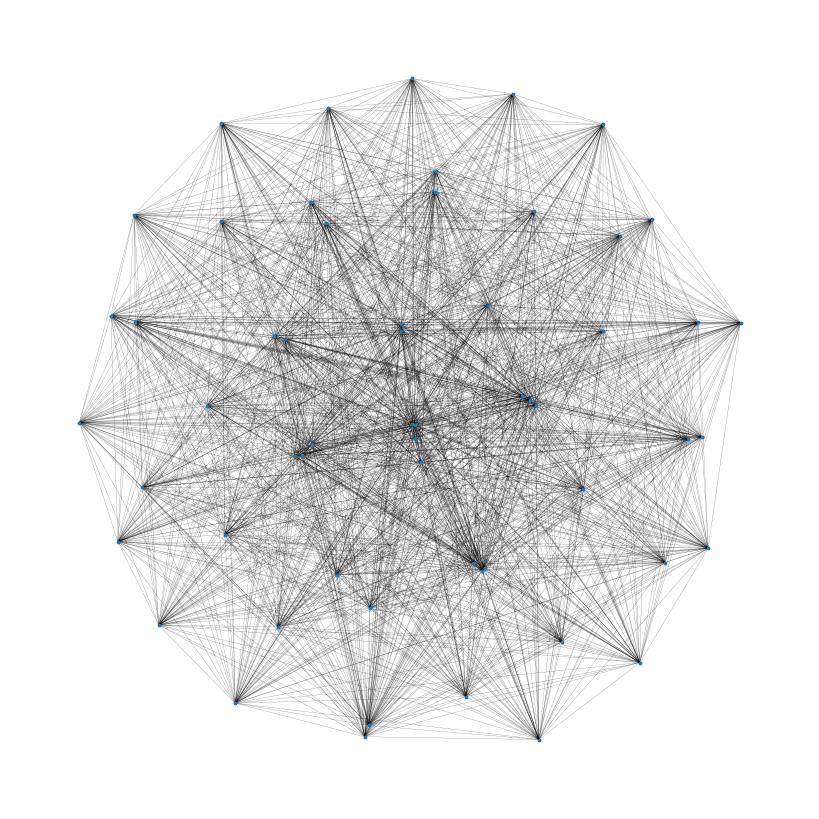

In [13]:
# output the graph using matplotlib
import matplotlib.pyplot as plt
width = 8
plt.figure(figsize=(width, width))
layout = nx.spring_layout(graph, seed=3, k = .5, iterations=2000)
nx.draw(graph, with_labels=False, node_size=3, width=0.1, pos=layout)

In [14]:
import numpy as np

def convert_graph_to_matrix(graph):
    """
    Converts a NetworkX graph into a NumPy matrix.
    Assumes that the graph is complete (i.e., there is an edge between every pair of nodes).

    :param graph: NetworkX graph
    :return: NumPy matrix representing the distances between nodes
    """
    # Create a NumPy matrix of zeros
    n = len(graph.nodes)
    matrix = np.zeros((n, n))

    # Populate the matrix with distances
    for i, node_i in enumerate(graph.nodes):
        for j, node_j in enumerate(graph.nodes):
            if i != j:
                try:
                    # Attempt to get the 'weight' attribute for the edge
                    matrix[i][j] = graph[node_i][node_j]['weight']
                except KeyError:
                    # If the edge does not exist or has no weight, set a large number
                    matrix[i][j] = float('inf')

    return matrix

# Convert the graph into a NumPy matrix
matrix = convert_graph_to_matrix(graph)
print(matrix)

[[   0. 2635. 2713. ... 3870. 1417.  739.]
 [2635.    0.  314. ... 2072. 1196. 1517.]
 [2713.  314.    0. ... 1882. 2699. 1557.]
 ...
 [3870. 2072. 1882. ...    0. 2328. 2986.]
 [1417. 1196. 2699. ... 2328.    0.  962.]
 [ 739. 1517. 1557. ... 2986.  962.    0.]]

In [15]:
import numpy as np
import random

class AntColonyOptimizer:
    def __init__(self, distance_matrix, num_ants, evaporation_rate, alpha, beta, Q, max_fitness_evaluations, show_progress=False):
        self.distance_matrix = np.triu(distance_matrix)
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.max_fitness_evaluations = max_fitness_evaluations
        self.num_cities = distance_matrix.shape[0]
        self.show_progress = show_progress
        
        # Initialize heuristic information 
        self.eta = np.zeros_like(self.distance_matrix)
        upper_triangle_indices = np.triu_indices_from(self.distance_matrix, k=1)
        self.eta[upper_triangle_indices] = 1.0 / (self.distance_matrix[upper_triangle_indices] + np.finfo(float).eps)

        # Initialize pheromone levels
        self.pheromone_matrix = np.random.uniform(low=0.1, high=1.0, size=(self.num_cities, self.num_cities))

    def run(self):
        best_cost = float('inf')
        best_solution = None
        fitness_evaluations = 0

        while fitness_evaluations < self.max_fitness_evaluations:
            solutions = []

            for _ in range(self.num_ants):
                solution, cost = self.generate_solution()
                solutions.append((solution, cost))

                if cost < best_cost:
                    best_cost = cost
                    best_solution = solution

                fitness_evaluations += 1
                if fitness_evaluations >= self.max_fitness_evaluations:
                    break

            self.update_pheromones(solutions)
            self.evaporate_pheromones()

        return best_solution, best_cost

    def generate_solution(self):
        path = np.full(self.num_cities, -1)  # Pre-allocate memory for the path array
        start_city = random.randint(0, self.num_cities - 1)
        path[0] = start_city
        visited = set([start_city])  # Start with the first city in the visited set

        for i in range(1, self.num_cities):
            current_city = path[i - 1]
            next_city = self.select_next_city(current_city, visited)
            path[i] = next_city
            visited.add(next_city)

        cost = self.calculate_path_cost(path)
        return path.tolist(), cost  # Convert path back to list if necessary


    def select_next_city(self, current_city, visited):
        unvisited_mask = np.ones(self.num_cities, dtype=bool)
        unvisited_mask[list(visited)] = False
        unvisited_cities = np.arange(self.num_cities)[unvisited_mask]

        tau = self.pheromone_matrix[current_city, unvisited_cities] ** self.alpha
        eta = self.eta[current_city, unvisited_cities] ** self.beta
        probabilities = tau * eta

        total = np.sum(probabilities)
        if total <= 0:
            # Fallback: Choose randomly from remaining unvisited cities
            if unvisited_cities.size > 0:
                return np.random.choice(unvisited_cities)
            else:
                raise Exception("No unvisited cities left, but path is incomplete. Check logic.")

        # Create cumulative probability distribution
        cumulative_prob = np.cumsum(probabilities) / total

        # Use searchsorted to find the next city
        next_city_index = np.searchsorted(cumulative_prob, np.random.random())
        next_city = unvisited_cities[next_city_index]

        return next_city

    def calculate_path_cost(self, path):
        path_array = np.array(path)
        from_cities = path_array[:-1]
        to_cities = path_array[1:]

        # Ensure indices for accessing upper triangular matrix
        min_indices = np.minimum(from_cities, to_cities)
        max_indices = np.maximum(from_cities, to_cities)

        # Vectorized access to the triangular matrix
        cost = np.sum(self.distance_matrix[min_indices, max_indices])

        # Add cost of returning to the start
        start, end = min(path[0], path[-1]), max(path[0], path[-1])
        cost += self.distance_matrix[start, end]

        return cost

    def update_pheromones(self, solutions):
        pheromone_delta = np.zeros_like(self.pheromone_matrix)  # Matrix to store pheromone updates

        for solution, cost in solutions:
            indices = np.array(solution)
            pheromone_delta[indices[:-1], indices[1:]] += self.Q / cost

        self.pheromone_matrix += pheromone_delta

    def evaporate_pheromones(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)

# Example usage
# Assuming you have a distance matrix 'distance_matrix' and set the parameters
aco = AntColonyOptimizer(matrix, num_ants=10, evaporation_rate=0.5, alpha=1, beta=2, Q=100, max_fitness_evaluations=10000)
best_solution, best_cost = aco.run()
# print("Best Solution:", best_solution)
# print("Best Cost:", best_cost)

# 12.7s

In [1]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product
from tqdm import tqdm

# ... (your AntColonyOptimizer class code here) ...

def run_aco_with_params(distance_matrix, num_ants, evaporation_rate, alpha, beta):
    aco = AntColonyOptimizer(distance_matrix, num_ants, evaporation_rate, alpha, beta, Q=100, max_fitness_evaluations=10000)
    best_solution, best_cost = aco.run()
    return best_cost, best_solution

def grid_search_aco(distance_matrix, num_ants_options, evaporation_rate_options, alpha_options, beta_options):
    with ProcessPoolExecutor() as executor:
        futures = {}
        for params in product(num_ants_options, evaporation_rate_options, alpha_options, beta_options):
            num_ants, evaporation_rate, alpha, beta = params
            future = executor.submit(run_aco_with_params, distance_matrix, num_ants, evaporation_rate, alpha, beta)
            futures[future] = params

        results = []
        for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating ACO Parameters"):
            result = future.result()
            param_set = futures[future]
            results.append((result, param_set))

    return results

distance_matrix = convert_graph_to_matrix(graph)
num_ants_options = [10, 30, 50, 70, 100]
evaporation_rate_options = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha_options = [0.5, 1, 2, 3]
beta_options = [0.5, 1, 2, 3]


results = grid_search_aco(distance_matrix, num_ants_options, evaporation_rate_options, alpha_options, beta_options)

# print only the best result
(best_cost, best_solution), best_param_set = min(results, key=lambda x: x[0][0])
print("Best Result:", best_cost)
print("Best Solution:", best_solution)
print("Best Parameter Set:", best_param_set)

NameError: name 'convert_graph_to_matrix' is not defined

In [ ]:
# import random
# from tqdm import tqdm

# class AntColonyOptimizer:
#     def __init__(self, graph, num_ants, evaporation_rate, alpha, beta, max_iterations, show_progress_bar = True):
#         self.graph = graph
#         self.num_ants = num_ants
#         self.evaporation_rate = evaporation_rate
#         self.alpha = alpha
#         self.beta = beta
#         self.max_iterations = max_iterations
#         self.show_progress_bar = show_progress_bar
        

#     def initialize_pheromones(self):
#         # Initialize pheromones on the edges
#         for u, v in self.graph.edges():
#             self.graph[u][v]['pheromone'] = random.uniform(0, 1)

#     def run(self):
#         self.initialize_pheromones()
#         best_cost = float('inf')
#         best_solution = None
        
#         if self.show_progress_bar:
#             r = tqdm(range(self.max_iterations), desc="Iterations", colour='green')
#         else:
#             r = range(self.max_iterations)

#         # Main loop with tqdm progress bar
#         for iteration in r:
#             paths = []  # List to store paths and costs for this iteration
#             for ant in range(self.num_ants):
#                 solution, cost = self.generate_solution()
#                 paths.append((solution, cost))  # Add the path and its cost
#                 if cost < best_cost:
#                     best_cost = cost
#                     best_solution = solution

#             # Update pheromones with the collected paths
#             self.update_pheromones(paths)

#             # Evaporate pheromones
#             self.evaporate_pheromones()

#         return best_solution, best_cost


#     def generate_solution(self):
#         path = []
#         visited = set()
#         current_city = random.choice(list(self.graph.nodes))
#         path.append(current_city)
#         visited.add(current_city)

#         while len(visited) < len(self.graph.nodes):
#             probabilities = self.calculate_transition_probabilities(current_city, visited)
#             next_city = self.select_next_city(probabilities)
#             path.append(next_city)
#             visited.add(next_city)
#             current_city = next_city

#         return path, self.calculate_path_cost(path)

#     def calculate_transition_probabilities(self, current_city, visited):
#         probabilities = {}
#         denominator = sum((self.graph[current_city][neighbor]['pheromone'] ** self.alpha) *
#                         ((1 / self.graph[current_city][neighbor]['weight']) ** self.beta)
#                         for neighbor in self.graph.neighbors(current_city) if neighbor not in visited)

#         for neighbor in self.graph.neighbors(current_city):
#             if neighbor not in visited:
#                 probabilities[neighbor] = ((self.graph[current_city][neighbor]['pheromone'] ** self.alpha) *
#                                         ((1 / self.graph[current_city][neighbor]['weight']) ** self.beta)) / denominator
#         return probabilities

#     def select_next_city(self, probabilities):
#         return max(probabilities, key=probabilities.get)

#     def calculate_path_cost(self, path):
#         cost = 0
#         for i in range(len(path) - 1):
#             cost += self.graph[path[i]][path[i + 1]]['weight']
#         cost += self.graph[path[-1]][path[0]]['weight']  # Return to start
#         return cost


#     def update_pheromones(self, paths):
#         for path, cost in paths:
#             deposit_amount = 1.0 / cost  # For example, can vary based on your problem specifics
#             for i in range(len(path) - 1):
#                 self.graph[path[i]][path[i + 1]]['pheromone'] += deposit_amount


#     def evaporate_pheromones(self):
#         for u, v in self.graph.edges():
#             self.graph[u][v]['pheromone'] *= (1 - self.evaporation_rate)


# # Assuming 'graph' is your NetworkX graph created from the XML data
# aco = AntColonyOptimizer(graph, num_ants=10, evaporation_rate=0.5, alpha=1, beta=2, max_iterations=10000)
# best_solution_orig, best_cost_orig = aco.run()



In [ ]:
# import itertools
# import networkx as nx
# from tqdm import tqdm
# from concurrent.futures import ProcessPoolExecutor
# import concurrent.futures

# # Define the ranges for each parameter
# num_ants_options = [10, 20, 30]
# evaporation_rate_options = [0.1, 0.5, 0.9]
# alpha_options = [1, 2, 3]
# beta_options = [1, 2, 3]
# Q = [100]
# max_fitness_evals = [10000]

# # Create a cartesian product of all parameter options
# parameter_combinations = list(itertools.product(
#     num_ants_options,
#     evaporation_rate_options,
#     alpha_options,
#     beta_options,
#     Q,
#     max_fitness_evals
# ))

# # Placeholder for the best parameter set and its associated cost
# best_params = None
# best_solution = None
# best_cost = float('inf')

# # (matrix, num_ants=10, evaporation_rate=0.5, alpha=1, beta=2, Q=100, max_fitness_evaluations=10000)

# # Function to run an individual experiment
# def run_experiment(params):
#     num_ants, evap_rate, alpha, beta, Q, max_fitness_evals = params
#     aco = AntColonyOptimizer(matrix, num_ants, evap_rate, alpha, beta, Q, max_fitness_evals)
#     solution, cost = aco.run()
#     return cost, params, solution

# # Running experiments in parallel
# best_cost = float('inf')
# best_params = None
# best_solution = None

# with ProcessPoolExecutor() as executor:
#     futures = [executor.submit(run_experiment, params) for params in parameter_combinations]

#     for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Grid Search", unit="comb", colour='green'):
#         cost, params, solution = future.result()
#         if cost < best_cost:
#             best_cost = cost
#             best_params = params
#             best_solution = solution

# print(f"Best parameters found: {best_params} with cost: {best_cost}")


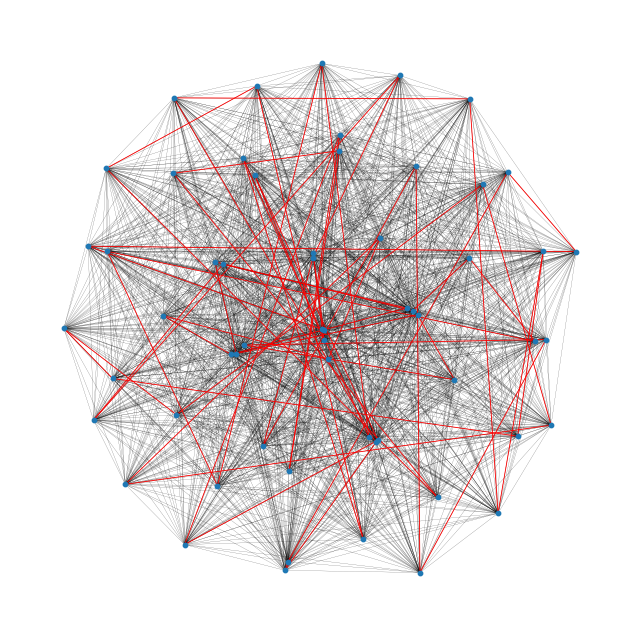

In [26]:
def draw_best_path(graph, best_path, pos):
    
    plt.figure(figsize=(width, width))

    # Draw the graph
    nx.draw_networkx_nodes(graph, pos, node_size=10)
    # nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges, width=0.1)

    # Extract edges from the path
    path_edges = [(best_path[i], best_path[i+1]) for i in range(len(best_path) - 1)]
    path_edges.append((best_path[-1], best_path[0]))  # Adding edge to complete the tour

    # Draw the path edges
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=.6)

    plt.axis('off')
    plt.show()


# convert the elements of the path to strings
best_solution = [str(x) for x in best_solution]
# Assuming 'graph' is your NetworkX graph and 'best_solution' is the best path found
draw_best_path(graph, best_solution, layout)


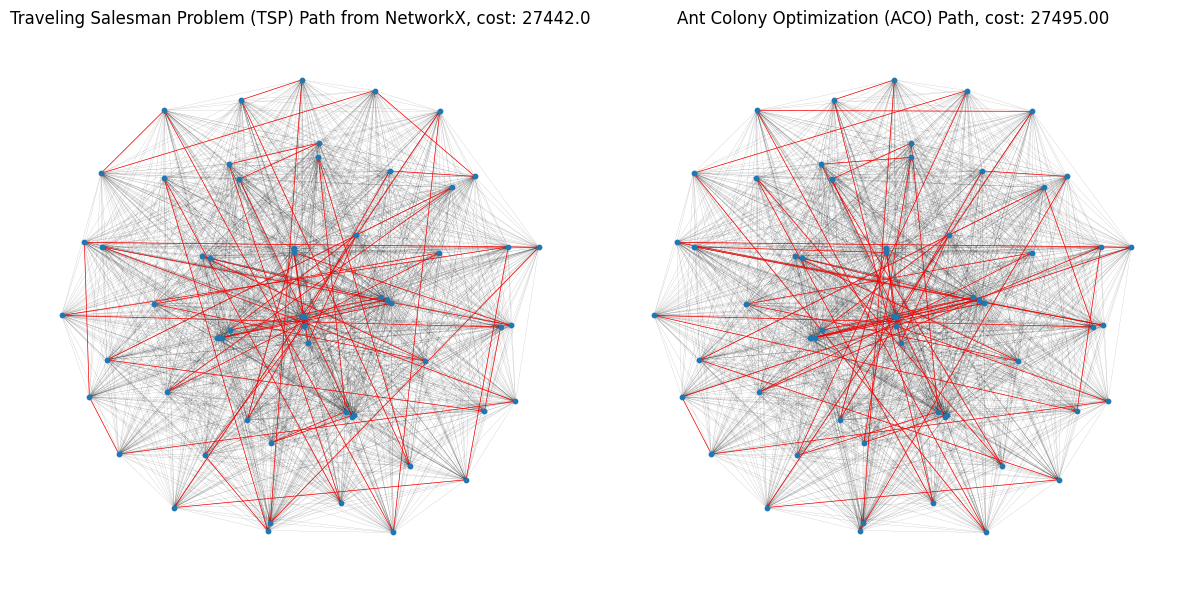

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Extract edges from the ACO path
path_edges = [(best_solution[i], best_solution[i+1]) for i in range(len(best_solution) - 1)]
path_edges.append((best_solution[-1], best_solution[0]))  # Adding edge to complete the tour
# Add the final edge to complete the tour


# Draw TSP path on the left subplot

import networkx.algorithms.approximation as nx_app
cycle = nx_app.christofides(graph, weight="weight")

edge_list = list(nx.utils.pairwise(cycle))
# Combine the two lists into a single networkx graph
tsp_g = nx.Graph()
tsp_g.add_nodes_from(graph.nodes)
tsp_g.add_edges_from(edge_list)

ax1.set_title(f'Traveling Salesman Problem (TSP) Path from NetworkX, cost: {sum(graph[u][v]["weight"] for u, v in edge_list)}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=10, ax=ax1)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.05, ax=ax1)
nx.draw_networkx_edges(tsp_g, pos=layout, width=0.5, edge_color='red', ax=ax1)
ax1.axis('off')

# Draw ACO path on the right subplot
ax2.set_title(f'Ant Colony Optimization (ACO) Path, cost: {best_cost:.2f}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=10, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.05, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=path_edges, width=0.5, edge_color='red', ax=ax2)
ax2.axis('off')



# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [13]:
# Weight of the TSP path found by NetworkX, use the weights of the edges from the original graph
tsp_cost = sum(graph[u][v]['weight'] for u, v in edge_list)
print(f"Cost of TSP Path with NetworkX: {tsp_cost}")


# Weight of the best path found by the ACO algorithm
print(f"Cost of Best Path with ACO: {best_cost}")

Cost of TSP Path with NetworkX: 27442.0

Cost of Best Path with ACO: 27495.0